Part 1: Downloading
==

The goal is to procure data for traffic counts on roads around Ireland, daily. This data has been made freely available by the Irish government.

The data is to come from: https://www.nratrafficdata.ie

The date range for which data is desired is defined in the cell below. 

If data has already been downloaded and these dates are changed, old data will not be deleted. Also, since the data is downloaded in monthly chunks, data from months at the start/end of the previous timeframe that only partially overlapped may be duplicated.

In [3]:
from datetime import date

START_DATE = date(2020, 1, 1)
END_DATE = date(2021, 1, 26)

Alas, the site does not allow a blanket download of data. The data for each road needs to be queried individually. Furthermore, to avoid overloading the site's capabilities as of writing this, the timeframe requested should be short (at most a few months).

Their website has javascript containing an array of the road locations and indentifiers, which has been transformed into "road-info.csv", loaded below. From these requests for each month and road can be generated. There are 374 locations, and I'm limiting each query to one month only, so 4862 requests are needed to retrieve data for 2020 and january of 2021.

In [4]:
import pandas as pd

info = pd.read_csv("road-info.csv")
info

,nra,num,cosit,TMU,location,lat,lng
0,NRA,997,NRA_000000000997,NRA - test site,Test site for AFMS,53.39890,-6.34177
1,NRA,1011,NRA_000000001011,TMU N01 000.0 N,M01 Airport Link Road Between R132 Swords Road...,53.42808,-6.22453
2,NRA,1012,NRA_000000001012,TMU M50 000.0 N,M50 Between Jn02 Santry and Jn03 M50\/M1,53.40305,-6.23350
3,NRA,1013,NRA_000000001013,TMU N01 040.0 S,"N01 South of M50 Jn02 Santry, Whitehall",53.38807,-6.24237
4,NRA,1014,NRA_000000001014,TMU M01 000.0 N,M01 Between Jn01 M50\/M01 and Jn02 Dublin Airport,53.41780,-6.22294
...,...,...,...,...,...,...,...
369,NRA,202103,NRA_000000202103,TMU N21 070.0 N,"N21 Castleisland Bypass, Mullaghmarky, Co. Kerry",52.24753,-9.48204
370,NRA,202104,NRA_000000202104,TMU N21 065.0 N,"N21 Castleisland Bypass, Dooneen, Co. Kerry",52.26234,-9.45752
371,NRA,202301,NRA_000000202301,TMU N23 010.0 S,"N23 Castleisland Bypass, Kealgorm, Co. Kerry",52.22455,-9.47804
372,NRA,202639,NRA_000000202639,TMU R639 010.0 S,"R639 Between Exit 15 of M08 and Rathcormac, Co...",52.08494,-8.27791


Utility function to get the start and end date of a month in a given year.

If the end date is today or later, set it to yesterday - we can't download data that doesn't exist yet.

In [5]:
from datetime import timedelta

def get_date_range(month, year):
    
    start_date = date(year, month, 1)
    
    if month == 12:
        end_date = date(year + 1, 1, 1) - timedelta(days=1)
        
    else:
        end_date = date(year, month + 1, 1) - timedelta(days=1)
        
    if start_date > END_DATE:
        raise ValueError("This month seems to come from after the declared END_DATE!")
        
    if end_date > END_DATE:
        end_date = END_DATE
        
    return start_date, end_date


print(get_date_range(2, 2020))
print(get_date_range(12, 2020))
print(get_date_range(date.today().month, date.today().year))

(datetime.date(2020, 2, 1), datetime.date(2020, 2, 29))
(datetime.date(2020, 12, 1), datetime.date(2020, 12, 31))
(datetime.date(2021, 1, 1), datetime.date(2021, 1, 26))


Second tiny utility to get a date as a string. The format is important here, since it matches the format expected by the GET query to the NRA website

In [6]:
def date_to_str(date):
    
    format_str = "%Y-%m-%d"
    return date.strftime(format_str)


For the purposes of general sanity, prepare the queries and target locations ahead of time

In [7]:
# Example download URL:
# https://www.nratrafficdata.ie/c2/tfdaysreport.asp?sgid=ZvyVmXU8jBt9PJE$c7UXt6&spid={identifier}&reportdate=2020-12-01&enddate=2021-01-22&excel=1'
    
def get_url(identifier, start_date, end_date):
    
    start_date = date_to_str(start_date)
    end_date = date_to_str(end_date)
    
    url = 'https://www.nratrafficdata.ie/c2/tfdaysreport.asp?'
    url += 'sgid=ZvyVmXU8jBt9PJE$c7UXt6'
    url += f'&spid={identifier}'
    url += f'&reportdate={start_date}'
    url += f'&enddate={end_date}'
    url += '&excel=1'
    url += '&intval=11'
    
    return url


data_folder_name = "Data"
raw_folder_name = "Raw"

months = list(range(1, 13)) + [1]
years = [2020] * 12 + [2021]
cosits = info.cosit
nums = info.num

records = list()
folder_names = set()

for month, year in zip(months, years):
    for id_nums, cosit in zip(nums, cosits):
        
        start_date, end_date = get_date_range(month, year)

        folder_name = date_to_str(start_date) + " - " + date_to_str(end_date)
        folder_names.add(folder_name)
        
        base_path = folder_name + "/" + cosit + ".xls"    
        path = data_folder_name + "/" + base_path
        raw_path = data_folder_name + "/" + raw_folder_name + "/" + base_path
        
        url = get_url(cosit, start_date, end_date)
        
        records.append([id_nums, cosit, start_date, end_date, raw_path, url])
            
queries = pd.DataFrame(records, columns=["num", "cosit", "start_date", "end_date", "raw_path", "url"])
queries.tail(4)

,num,cosit,start_date,end_date,raw_path,url
4858,202104,NRA_000000202104,2021-01-01,2021-01-26,Data/Raw/2021-01-01 - 2021-01-26/NRA_000000202...,https://www.nratrafficdata.ie/c2/tfdaysreport....
4859,202301,NRA_000000202301,2021-01-01,2021-01-26,Data/Raw/2021-01-01 - 2021-01-26/NRA_000000202...,https://www.nratrafficdata.ie/c2/tfdaysreport....
4860,202639,NRA_000000202639,2021-01-01,2021-01-26,Data/Raw/2021-01-01 - 2021-01-26/NRA_000000202...,https://www.nratrafficdata.ie/c2/tfdaysreport....
4861,208001,NRA_000000208001,2021-01-01,2021-01-26,Data/Raw/2021-01-01 - 2021-01-26/NRA_000000208...,https://www.nratrafficdata.ie/c2/tfdaysreport....


Setting up the folder structure

In [8]:
def setup_folders(paths):

    failed = list()
    
    for path in paths:
        try:
            os.mkdir(path)
        except:
            failed.append(path)

    created = len(paths) - len(failed)
    if created > 0:
        print(created, "folders created")

    if len(failed) > 0:

        snippet = ", ".join(failed[:3])
        message = "Failed to create " + snippet

        remaining = len(failed) - 3
        if remaining > 0:
            message += " and " + str(remaining) + " other folder(s)"

        print(message)
        print("This is normal if these folders already exist")
        

paths = list()

paths.append(data_folder_name)
paths.append(data_folder_name + "/" + raw_folder_name)

for name in folder_names:
    paths.append(data_folder_name + "/" + raw_folder_name + "/" + name)
    
setup_folders(paths)

Failed to create Data, Data/Raw, Data/Raw/2020-02-01 - 2020-02-29 and 12 other folder(s)
This is normal if these folders already exist


Downloading from a single url to a target path, using the "requests" library

In [9]:
import requests
import os
import time


def download(url, destination_path):
    
    # An extra little wait to give the server time between repeated
    # downloads
    time.sleep(1)
    
    print("Url:", url)
    print("Path:", destination_path)
    
    try:
        response = requests.get(url)
        if response.ok:
            with open(destination_path, "wb") as file:
                file.write(response.content)
            
            print("Download complete!")
            return True
        else:
            print("Download failed")
            return False
    
    except Exception as e:
        print("Error occured")
        print(e)
        return False
    

def download_all(skip_to = 0):
    
    error_count = 0
    skip_count = 0
    success_count = 0
    
    skipping = False
    
    for i in range(skip_to, len(queries)):
        
        url = queries.url[i]
        path = queries.raw_path[i]
        cosit = queries.cosit[i]
        
        if os.path.isfile(path):
            skip_count += 1
            skipping = True
            continue
        
        # Print a skip count after skipping has ended
        if skipping:
            print("------------------")
            print("Skip Count:", skip_count)
            print("------------------")
            skipping = False
        
        success = download(url, path)
        
        print(f"Item {i+1}/{len(queries)}:", cosit)
        
        if success:
            success_count += 1
        else:
            error_count += 1
        
        # Print the occasional error report
        actions = success_count + error_count
        if actions != 0 and actions % 15 == 0:
            print("------------------")
            print("Error count:", error_count)
            print("------------------")
    
    print("==============")
    print("== Complete ==")
    print("==============")
    print("Download count:", success_count)
    print("Error count:", error_count)
    print("Skip count:", skip_count)



Perform the download. If the data is already present, it won't be reaquired. To redownload data, delete the ones to be redownloaded.

In [10]:
download_all()

== Complete ==
Download count: 0
Error count: 0
Skip count: 4862


Part 2: Interpreting
==

The verification step is important here, since the process isn't perfect. Some files might be missing or incorrectly named. Luckily, the files contain a header describing their contents, so we can verify and correct mistakes, and highlight missing files.

One problem: the files are in an odd format. It might be an old excel format, though while the excel application can read the file, it claims that the format is unrecognized.

Luckily, it seems to be a subset of html. So the next step is to read the file as xml and extract the data into python-friendly tables.

The code for extraction is below. A more complete discussion of it is in a separate file. The data is being read as a plain old list of lists for now, pandas will come later. 

In [11]:
import bs4

# Read one of those odd xls files into a table in the form 
# of a list of lists
def read_xls(path, first_cell_only = False):
    with open(path) as file:
        root = bs4.BeautifulSoup(file.read())
        return soup_to_table(root, first_cell_only)
    
    
# Define elements to ignore, but whose children should not be ignored
pass_through = ["div", "b", "td", "th", "body", "ul", "html", "p", "table"]

# Define elements to ignore entirely, including children
ignore = ["Doctype", "Comment", "style", "script", "head", "br"]


# Create a table (in the form of a list of lists) from a 
# BeautifulSoup root element
def soup_to_table(element, first_only):

    result = list()   

    add_element(result, element, first_only)
    
    return result
    

# Add the contents of a BeautifulSoup element to the table.
def add_element(table, element, first_only, row_started = False):

    name = type(element).__name__

    if name in ignore:
        return

    elif name == "BeautifulSoup":
        
        if element.html == None:
            return
        
        add_element(table, element.html, first_only) 
    
    elif name == "Tag":
        add_tag(table, element, first_only, row_started)

    elif name == "NavigableString":
        add_string(table, element, row_started)

    else:
        raise TypeError(table, "Unrecognized element type:", name)


# Add the contents of a html tag to the table
def add_tag(table, element, first_only, row_started):

    if element.name in ignore:
        # Ignore this element and its children
        return

    if element.name in pass_through:
        # Ignore this element, but add its children
        for child in element.children:
            add_element(table, child, first_only, row_started)
            if first_only and len(table) > 0: break

        return

    if element.name != "tr":
        # The only element we're interested in giving special
        # meaning to is the <tr> element
        raise ValueError("Unrecognized tag name:", element.name)


    if row_started:
        raise ValueError("There seem to be nested <tr> elements in the tree")

    # Start a new row
    table.append(list())
    row_started = True

    # Add children
    for child in element.children:
        add_element(table, child, first_only, row_started)
        if first_only and len(table[0]) > 0: break

    # End the row
    row_started = False
    
    # If the row was empty, don't keep it
    if len(table[-1]) == 0:
        table.pop()
        
    

# Add the contents of a BeautifulSoup string tree element to
# a table.
def add_string(table, element, row_started):

    text = element.string.strip()

    if text == "":
        # Ignore empty cells and rows
        return

    if row_started:
        table[len(table) - 1].append(text)

    else:
        # If no row is in progress, this is a string on its own
        # Treat it as a single-cell row
        table.append([text])

Print out the first 10 lines of a file as a test

In [12]:
read_xls(queries.raw_path[0])[:10]

[['Multi-Day Volume Report NRA 000000000997 2020-01-01 to 2020-01-31'],
 ['Site Name', 'NRA - test site'],
 ['Site ID', '000000000997'],
 ['Grid', '310350240006'],
 ['Description', 'Test site for AFMS'],
 ['Setup', 'Test'],
 ['Channel', 'Each Direction'],
 ['Time Period', '24 hours'],
 ['Class', 'Any'],
 ['Exclude data:', 'None']]

Part 3: Verifying
==

Now that they can be read, time to make sure they make sense.

Step one is to check the headers against the query, and make sure that the data nominally matches the expectation. 

This shouldn't be a problem when using the requests library above, however, a previous iteration of this notebook used the webbrowser python library in a much more messy way and some of the data was incorrectly named. There is no harm in keeping the check.

In [13]:
import re


error_count = 0
error_queries = list()


def reset_error():
    
    error_queries.clear()
    
    global error_count
    error_count = 0


def check_error(index, query, *error_msg):

    print("------------")
    print("Error:")
    print(*error_msg)
    print("Index:", index)
    print("Query:")
    print(query)
    print("------------")

    global error_count
    error_count += 1
    error_queries.append([index,query])


def first_check(limit = None):

    reset_error()
    
    subjects = queries.values
    if limit is not None:
        subjects = subjects[:limit]

    pattern = re.compile("Multi-Day Volume Report NRA (\d{12}) (\d{4}-\d\d-\d\d) to (\d{4}-\d\d-\d\d)")
    
    for i, query in enumerate(subjects):

        if i != 0 and i % 50 == 0:
            print(f"Checked {i}/{len(subjects)}")
            print("Error count:", error_count)

        query = pd.Series(query, index=queries.columns)
        
        try:
            table = read_xls(query.raw_path, first_cell_only = True)
        except KeyboardInterrupt:
            print("Interrupted")
            break
        except Exception as e:
            check_error(i, query, "Unable to read table from file")
            continue

        if len(table) == 0:
            check_error(i, query, "Table is empty")
            continue
        elif len(table[0]) == 0:
            check_error(i, query, "First row is empty")
            continue

        header = table[0][0]

        match = pattern.fullmatch(header)

        if match is None:
            check_error(i, query, "Unable to parse header:", header)
            continue

        start = date_to_str(query.start_date)
        end = date_to_str(query.end_date)
        nra_num = str(query.num).rjust(12, "0")

        if nra_num != match.group(1):
            check_error(i, query, "Road ID mismatch. Expected:", nra_num, "Found:", match.group(1))
            continue

        if start != match.group(2):
            check_error(i, query, "Start date mismatch. Expected:", start, "Found:", match.group(2))
            continue

        if end != match.group(3):
            check_error(i, query, "End date mismatch. Expected:", end, "Found:", match.group(3))
            continue


    print(f"Checked {i+1}/{len(subjects)}")
    print("--------------")
    print("Check complete")
    print("--------------")
    print("Error count:", error_count)

This first check is very slow, hence usually commented out as below.

In [14]:
# first_check()

As expected, a number of mistakes were found, but after deleting and redownloading the files in question the check passed.

In [15]:
# for query in error_queries:
#     os.remove(query.raw_path)
    
# download_all()

# first_check()

As a second step, it would be nice to confirm a complete template of the data.

Below is a function for generating a general pattern that represents a current understanding of the data - a list of lists of regex patterns corresponding to expected cells in the table.

In [16]:
# Note: the text data has already been trimmed in the initial
# reading of the html into a table. Whitespace does not need to be considered here.


# Define a simple class to designate a row as optional
class Optional:
    def __init__(self, row_pattern, *paths):
        self.value = row_pattern
        self.paths = paths


# Define some path constants. Path0 is never actually used, though
# it has a special meaning later on. I really overcomplicated this
# for no good reason!
Path0 = 0
Path1 = 1
Path2 = 2
        
        
def expected_pattern(query):
    
    start = date_to_str(query.start_date)
    end = date_to_str(query.end_date)

    padded_num = str(query.num).rjust(12, "0")
    
    count = query.end_date.day

    dates = list()
    reference_date = query.start_date
    for i in range(count):
        current_date = date(reference_date.year, reference_date.month, i + 1)
        dates.append(date_to_str(current_date))
    
    return [

        # There are actually only two lines of interest here, marked below.
        # It is still useful to confirm the structure of the rest of them, since that
        # in turn helps confirm the indentity of the ones that are important.
        
        [f"Multi-Day Volume Report NRA {padded_num} {start} to {end}"],
        ['Site Name', '.+'],
        ['Site ID', f'{padded_num}'],
        ['Grid', '\d+'],
        ['Description', '.+'],
        ['Setup', '.+'],
        ['Channel', 'Each Direction'],
        
        # It seems like some of the data has this "Bins" line, instead of the 
        # "Class" line below. To capture this in validation, mark each as optional and
        # being on separate paths. This means that one, and only one, of these lines
        # is required for the pattern to match successfully.
        
        Optional(['Bins', 'Total'], Path2),
        
        ['Time Period', '24 hours'],
        
        Optional(['Class', 'Any'], Path1),
        
        ['Exclude data:', 'None'],
         
        ['All directions'],
        ["\w\w\w"] * count + ["Average", "Total"],
        
        # This is one of the two lines that is of interest - the index of dates
        # This is row 12.   (zero based index)
        dates + ["Workday", "7 Day", "Count"],
        
        ['00:00:00'] + ["\d+"] * (count + 3),
        ['07-19'],
        ['06-22'],
        ['06-24'],
        
        # Daily traffic counts. This is the only other line of interest, and the only data of interest.
        # This is row 17.   (zero based index)
        ['00-24'] + ["\d+"] * (count + 3),

        ['am Peak'] + ["00:00:00"] * (count + 2),
        ['Peak Volume'] + ["\d+"] * (count + 2),
        ['pm Peak'] + ["00:00:00"] * (count + 2),
        ['Peak Volume'] + ["\d+"] * (count + 2)
        
        # There are more lines after the ones above, but they will be
        # ignored for now. They contain directional data and their format
        # is more variable and more difficult to capture in a pattern, much
        # less read data from.
        
    ]



Code to actually check this pattern - looping through the 2D array and comparing regex patterns to cell values

The optional rows do make this completely overcomplicated, though.

When an optional row is encountered, it is checked like any other. If it fails, its paths are marked off the list of possible paths. If all paths have been marked off, the pattern doesn't match. If an optional row is parted with Path0, the row is fully optional and it failing has no effect on the pattern.

In [17]:
import re


# Gets the list of path IDs, and the 
# minimum number of rows accross all paths
def get_path_info(pattern):
    
    base_count = 0
    extra_counts = {}
    
    for row in pattern:
        
        # If the row is optional, ie. is a part of one or
        # more paths, increment the counts for those paths only
        if isinstance(row, Optional):
            for path in row.paths:
                if not path in extra_counts:
                    extra_counts[path] = 0
                extra_counts[path] += 1
        
        else:
            # Else, it's a part of all paths, increment
            # the base count
            base_count += 1
            
    # The total minimum count is the base count plus
    # the length of the shortest path?
    if len(extra_counts) > 0:
        base_count += min(extra_counts.values())
    
    return extra_counts.keys(), base_count
    

# Compare a single row against a single row pattern. Return a message
# if there is a mismatch.
def check_row(row_index, row, row_pattern):
    
    # Early out - does the row have the expected number of cells?
    if len(row) != len(row_pattern):

        message = f"Row {row_index} has an unexpected number of cells."
        message += " Expected: " + str(len(row_pattern))
        message += " Actual: " + str(len(row))

        return message
        
    # Loop through each cell, compare the pattern with regex
    for i, (cell, cell_pattern) in enumerate(zip(row, row_pattern)):
        if not re.fullmatch(cell_pattern, cell):

            message = f"Cell {row_index},{i} does not match expected pattern."
            message += " Expected: '" + cell_pattern + "'"
            message += " Actual: '" + cell + "'"

            return message
    
    
# Compare the full pattern against the table, accounting for
# Optional elements and paths.
def check(table, pattern):
    
    paths, min_rows = get_path_info(pattern)
    
    # Quick early out - does the table have enough
    # rows to satisfy any path?
    if len(table) < min_rows:
        
        message = "Table has less rows than expected."
        message += " Minimum Expected: " + min_rows
        message += " Actual: " + str(len(table))
        
        return message
    
    
    # If Optional rows fail to match, this will exclude 
    # the paths it is a part of. If no paths are left, then
    # the match has failed.
    paths = set(paths)
    path_errors = {}
    general_error = None
    
    i, j = 0, 0
    while i < len(table) and j < len(pattern):
        
        row = table[i]
        row_pattern = pattern[j]
        
        # Whether or not the current row pattern matches the current
        # row. If this is false after checks, and the row is mandatory,
        # the pattern fails to match. The row pattern could be optional, though.
        match = True
        
        if isinstance(row_pattern, Optional):

            message = check_row(i, row, row_pattern.value)
            
            # If the error message is not None and the 
            # paths have failed, note the error and
            # exclude them.
            
            if message is not None:
                
                match = False
                
                if Path0 in row_pattern.paths:
                    # Path0 indicates that the path is fully optional,
                    # and we should not worry about it failing.
                    continue
                
                for path in row_pattern.paths:
                    
                    # Do check if we've removed it before first though
                    # Overwriting the previous error that first stopped it
                    # would be unintuitive.
                    
                    if path in paths:
                        paths.remove(path)
                        path_errors[path] = message
             
        # Else, it's just a plain old mandatory row.
        else:
            message = check_row(i, row, row_pattern)
            if message is not None:
                match = False
                paths.clear()
                general_error = message
        
        # Paths have been exhausted, the pattern doesn't match.
        if len(paths) == 0:
            
            # A general error means that a mandatory line
            # doesn't match and all paths fail.
            message = general_error
            
            # No general error means each path must have failed
            # individually.
            if message == None:
                errors = [f"Path {k}: {v}" for (k,v) in path_errors]
                message = "\n".join(errors)
                
            return message
        
        # Match or no match, there are paths left
        # to check, since the function hasn't returned this
        # iteration. Move on to the next pattern row.
        j += 1
        
        # Only move onto the next table row if the current
        # one successfully matched, though
        if match:
            i += 1

                

Now, create the pattern and check it against the downloaded file for each query.

In [18]:
def second_check(limit = None, verbrose = False):

    reset_error()

    subjects = queries.values
    if limit is not None:
        subjects = subjects[:limit]
    
    for i, query in enumerate(subjects):

        if verbrose and i != 0 and i % 50 == 0:
            print(f"Checked {i}/{len(subjects)}")
            print("Error count:", error_count)

        query = pd.Series(query, index=queries.columns)
            
        pattern = expected_pattern(query)
        table = read_xls(query.raw_path)
        
        message = check(table, pattern)
        if message is not None:
            check_error(i, query, message)

    print(f"Checked {i+1}/{len(subjects)}")
    print("--------------")
    print("Check complete")
    print("--------------")
    print("Error count:", error_count)

Again, this is very slow, and so usually commented out.

In [19]:
# second_check()

After running the second check, and again, redownloading files put in question, there remain 280 errors. 218 seem to correspond to files with no data at all, while the remaining 62 files contain some data but not all. 

These seem to be server-side errors/missing data, nothing much to be done about it. 

For simplicity and because 62/4000 files isn't all that much no attempt is made here to save the partial files.

The cell below notes the missing data in the queries DataFrame. It's usually commented out since it needs the previous "second_check()" cell to have been uncommented and run in order to be valid. Saving it to a csv means that the slow checks don't have to be rerun if the data hasn't changed, but if the data has changed, these lines should be uncommented and the error data updated.

In [20]:
# error_query_index = [i for (i,query) in error_queries]
# error_query_data = [query for (i,query) in error_queries]

# error_data_save = pd.DataFrame(error_query_data, index = error_query_index)
# error_data_save.to_csv("Data/Raw/errors.csv")

# error_data_save

In the meantime, unless the error data has just been updated, it needs to be loaded

In [21]:
error_data = pd.read_csv("Data/Raw/errors.csv", index_col = 0)
error_data

,num,cosit,start_date,end_date,path,raw_path,url
87,1301,NRA_000000001301,2020-01-01,2020-01-31,Data/2020-01-01 - 2020-01-31/NRA_000000001301.xls,Data/Raw/2020-01-01 - 2020-01-31/NRA_000000001...,https://www.nratrafficdata.ie/c2/tfdaysreport....
88,1302,NRA_000000001302,2020-01-01,2020-01-31,Data/2020-01-01 - 2020-01-31/NRA_000000001302.xls,Data/Raw/2020-01-01 - 2020-01-31/NRA_000000001...,https://www.nratrafficdata.ie/c2/tfdaysreport....
89,1303,NRA_000000001303,2020-01-01,2020-01-31,Data/2020-01-01 - 2020-01-31/NRA_000000001303.xls,Data/Raw/2020-01-01 - 2020-01-31/NRA_000000001...,https://www.nratrafficdata.ie/c2/tfdaysreport....
92,1321,NRA_000000001321,2020-01-01,2020-01-31,Data/2020-01-01 - 2020-01-31/NRA_000000001321.xls,Data/Raw/2020-01-01 - 2020-01-31/NRA_000000001...,https://www.nratrafficdata.ie/c2/tfdaysreport....
94,1401,NRA_000000001401,2020-01-01,2020-01-31,Data/2020-01-01 - 2020-01-31/NRA_000000001401.xls,Data/Raw/2020-01-01 - 2020-01-31/NRA_000000001...,https://www.nratrafficdata.ie/c2/tfdaysreport....
...,...,...,...,...,...,...,...
4814,20562,NRA_000000020562,2021-01-01,2021-01-26,Data/2021-01-01 - 2021-01-26/NRA_000000020562.xls,Data/Raw/2021-01-01 - 2021-01-26/NRA_000000020...,https://www.nratrafficdata.ie/c2/tfdaysreport....
4836,32501,NRA_000000032501,2021-01-01,2021-01-26,Data/2021-01-01 - 2021-01-26/NRA_000000032501.xls,Data/Raw/2021-01-01 - 2021-01-26/NRA_000000032...,https://www.nratrafficdata.ie/c2/tfdaysreport....
4837,32502,NRA_000000032502,2021-01-01,2021-01-26,Data/2021-01-01 - 2021-01-26/NRA_000000032502.xls,Data/Raw/2021-01-01 - 2021-01-26/NRA_000000032...,https://www.nratrafficdata.ie/c2/tfdaysreport....
4838,150141,NRA_000000150141,2021-01-01,2021-01-26,Data/2021-01-01 - 2021-01-26/NRA_000000150141.xls,Data/Raw/2021-01-01 - 2021-01-26/NRA_000000150...,https://www.nratrafficdata.ie/c2/tfdaysreport....


Part 4: Combining and Final Output
==

Last but not least, combine the monthly data into one big long data series for each location, and output these as plain csv.

Setting up folder structure.

In [22]:
setup_folders(["Data", "Data/Parsed"])

Failed to create Data, Data/Parsed
This is normal if these folders already exist


Preparing output info.

In [23]:
records = list()

for cosit in info.cosit:
    
    path = "Data/Parsed/" + cosit + ".csv"
    
    errors = False
    targets = queries[queries.cosit == cosit]
    for i in targets.index:
        if i in error_data.index:
            errors = True
    
    records.append([path, errors])
    

parsed_info = pd.DataFrame(records, index = info.cosit.values, columns = ["path", "errors"])
parsed_info.to_csv("Data/Parsed/index.csv")

Side note: the missing data seems to be focused in specific locations at least, rather than spread out across them all.  There are 280 missing months, but only 52 of 374 locations with missing data.

In [24]:
# len(parsed_info[parsed_info.errors == True])

Next, a function for combining the data for a single location across all months into a single data series.

The only relevant line of data is the line of daily traffic counts. Having validated the template pattern above, it seems like the precise line number of this data is always constant, even when the header format changes a little. 

The data is on row 17. Row 12, with the dates, is also useful, since it allows double-checking of the index.

At this point, missing data is simply marked with NaNs. Trying to fill in a sensible guess for it is beyond the scope of this document.

In [25]:
def collect(cosit):
    
    output_path = parsed_info.path[cosit]
    targets = queries[queries.cosit == cosit]

    dates = list()
    counts = list()

    for i, query in zip(targets.index, targets.values):

        query = pd.Series(query, index = queries.columns)

        # Construct an index of dates for that query

        n_days = query.end_date.day
        month = query.end_date.month
        year = query.end_date.year

        dates_i = list()
        for j in range(n_days):
            item = date(year, month, j + 1)
            dates_i.append(date_to_str(item))

        # Was the query successful?
        # If not, populate the counts with NaNs

        if i in error_data.index:
            dates.extend(dates_i)
            counts.extend([float("nan")] * len(dates_i))
            continue

        # Else, read the data that was downloaded

        table = read_xls(query.raw_path)

        # Proceeding with caution here: 
        # Some checks.

        if table[17][0] != "00-24":
            raise ValueError("Unexected cell value at beginning of cell counts: " + table[17][0])

        if table[12][0] != date_to_str(query.start_date):
            raise ValueError("Unexpected cell value for start date: " + table[12][0])

        downloaded_dates = table[12][:-3]
        counts_i = table[17][1:-3]

        if dates_i != downloaded_dates:
            print("Expected dates:", dates_i)
            print("Actual dates:", downloaded_dates)
            raise ValueError("Unexpected values for dates")
        
        if len(dates_i) != len(counts_i):
            print("Dates length:", len(dates_i))
            print("Counts length:", len(counts_i))
            raise ValueError("Length of dates index did not match length of count data")

        # Checks done. 
        # Add the data and move on.

        dates.extend(dates_i)
        counts.extend(counts_i)

    result = pd.DataFrame(counts, index = dates, columns = ["count"])
    return result

Finally, a function to collect and combine data for each location.

In [26]:
def collect_all():

    print("--------------")
    print("Collating Data")
    print("--------------")

    cosits = parsed_info.index
    paths = parsed_info.path.values
    targets = list(zip(cosits, paths))

    for i, (cosit, path) in enumerate(targets):

        collect(cosit).to_csv(path)

        if i != 0 and (i + 1) % 15 == 0:
            print(f"Progress: {i+1}/{len(targets)}")

    print(f"Progress: {i+1}/{len(targets)}")
    print("--------")
    print("Complete")
    print("--------")

This takes a long while to execute.

In [27]:
# collect_all()

Finally, a quick visualization (it does take a while to run though)

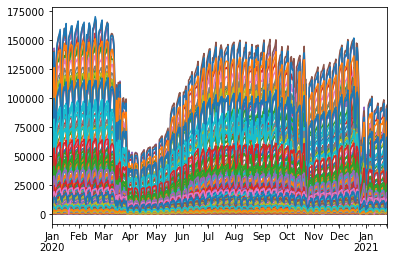

In [62]:
import matplotlib.pyplot as plt

plt.figure()

for index in range(2, len(parsed_info)):
    
    # Ignore time series with missing values
    if parsed_info.errors[index]:
        continue
    
    # Plot retrieve the data
    path = parsed_info.path[index]
    data = pd.read_csv(path, index_col=0, parse_dates=[0])
    data.columns = [parsed_info.index[index]]
    
    data.plot(ax=plt.gca(), legend = False)
